In [370]:
%matplotlib inline
from pandas import Series
from matplotlib import pyplot as plt
import geopandas as gpd
import pandas as pd
import random
from shapely.geometry import Point
import numpy as np
import geopandas as gpd
random.seed(35)

In [371]:
# on utilise la base de données des taxi dispo sur le site de NYC
data = 'C:/Users/Adrien/Desktop/bertille/Python projet/Python/yellow_tripdata_2016-06.csv'
df0 = pd.read_csv(data, sep=',')
df0 = df0[(df0['pickup_longitude'] < -73.7) & (df0['pickup_longitude'] > -74.1) & (df0['pickup_latitude'] > 40.4) & (df0['pickup_latitude'] < 51)]
df0=df0.where(df0.tip_amount.notna())
df0 = df0[df0.payment_type==1]
# si on veut on peut prendre un echantillon : df = df0.sample(100).reset_index()

# Introduction : apperçu des données
Nous disposons des données sur les tips par carte bancaire sur le mois de juin 2016. Après avoir récupéré dans la base principale les données concernant les paiements par carte bancaire et les observations respectant certaines conditions (nous éliminons notamment les individus qui sortent de la zone), il nous reste 7227844 observations Nous allons créer une série temporelle des moyennes par demi-heure des tips au cours du mois. Nous allons ensuite étudier cette série temporelle.

In [372]:
print(df0.shape)
df0.head()

(7227844, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
1,2,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.22,-73.981720,40.736668,1,N,-73.981636,40.670242,1,22.0,0.5,0.5,4.00,0.0,0.3,27.30
2,2,2016-06-09 21:06:36,2016-06-09 21:13:10,1,1.26,-73.994316,40.751072,1,N,-74.004234,40.742168,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-06-09 21:06:36,2016-06-09 21:36:10,1,7.39,-73.982361,40.773891,1,N,-73.929466,40.851540,1,26.0,0.5,0.5,1.00,0.0,0.3,28.30
4,2,2016-06-09 21:06:36,2016-06-09 21:23:23,1,3.10,-73.987106,40.733173,1,N,-73.985909,40.766445,1,13.5,0.5,0.5,2.96,0.0,0.3,17.76
5,2,2016-06-09 21:06:36,2016-06-09 21:19:21,1,2.17,-73.995201,40.739491,1,N,-73.993202,40.762642,1,10.5,0.5,0.5,2.36,0.0,0.3,14.16


On crée une variable X_d_t où X_d_t = la médiane des tips newyorkais entre la demi-heure t-1 et la demi-heure t au jour d. Nous avons choisi de travailler sur la médiane plutôt que sur la moyenne. En effet, la moyenne donne des résultats assez proches, mais avec beaucoup de variabilité. Nous préférons donc utiliser la médiane, moins sensible à la présence de valeurs extrêmes dans l'heure. Voici à quoi ressemblent nos données après cette calcul des médianes par demi-heure :

In [373]:
ts = df0[['tpep_dropoff_datetime', 'tip_amount']].set_index('tpep_dropoff_datetime')
ts.index = pd.to_datetime(ts.index)
ts = ts[(ts.index >= '2016-06-01') & (ts.index < '2016-06-30')]
ts_hourly = ts.resample('H').mean()
ts_hourly.head()

,tip_amount
tpep_dropoff_datetime,
2016-06-01 00:00:00,2.741030
2016-06-01 01:00:00,2.981748
2016-06-01 02:00:00,2.657042
2016-06-01 03:00:00,2.755595
2016-06-01 04:00:00,3.530284


Visualisons ces données. On peut remarquer sur le graphique suivant une période d'un jour. Nous pouvons regarder de plus près ce qui se passe chaque jour pour voir ce qui marque le début de cette période.

#### Sur le mois

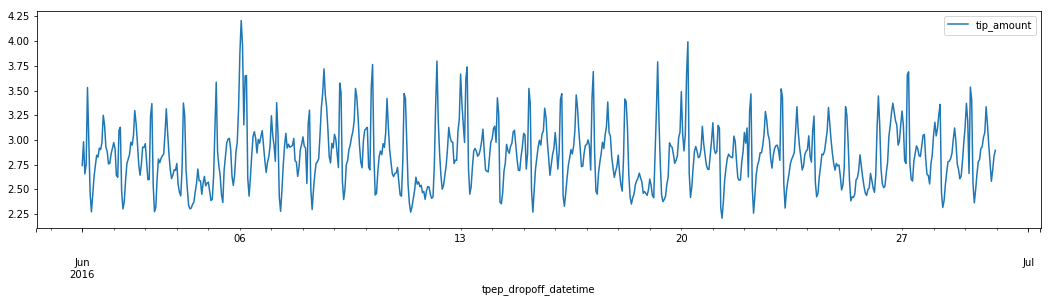

In [374]:
ts_hourly.plot(figsize=(18,4))

#### En semaine
Comme on peut le voir sur ces graphiques, il est fréquent d'observer une chute des pourboires la nuit

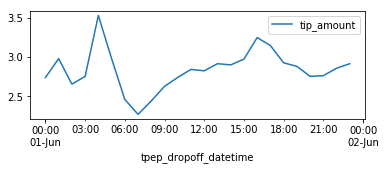

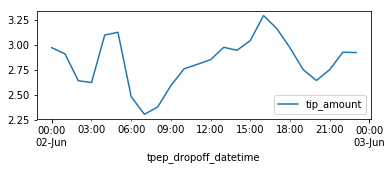

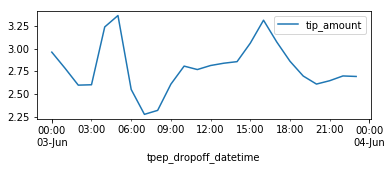

In [375]:
ts_hourly['2016-06-01'].plot(figsize=(6,2))
ts_hourly['2016-06-02'].plot(figsize=(6,2))
ts_hourly['2016-06-03'].plot(figsize=(6,2))

#### Le samedi
Cependant, regardons ce que l'on observe chaque samedi :

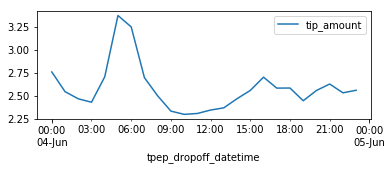

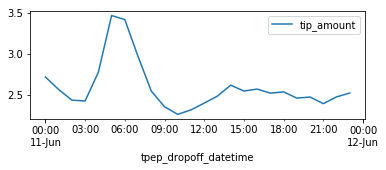

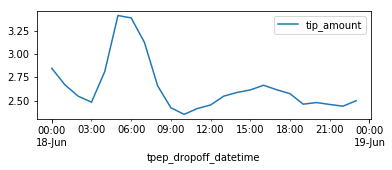

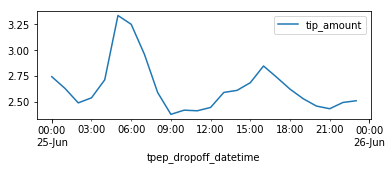

In [376]:
ts_hourly['2016-06-04'].plot(figsize=(6,2))
ts_hourly['2016-06-11'].plot(figsize=(6,2))
ts_hourly['2016-06-18'].plot(figsize=(6,2))
ts_hourly['2016-06-25'].plot(figsize=(6,2))

#### Le dimanche
Le dimanche, on a également des valeurs moyennes dans la nuit, une chute le matin à partir de 9h et une hausse en soirée.

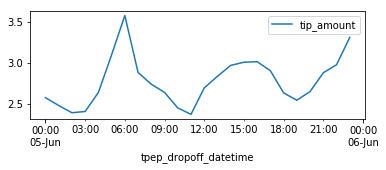

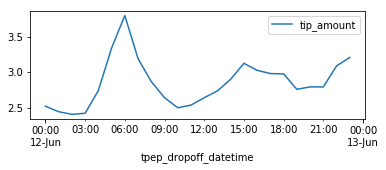

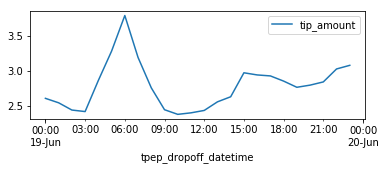

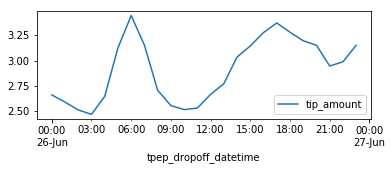

In [377]:
ts_hourly['2016-06-05'].plot(figsize=(6,2))

ts_hourly['2016-06-12'].plot(figsize=(6,2))

ts_hourly['2016-06-19'].plot(figsize=(6,2))

ts_hourly['2016-06-26'].plot(figsize=(6,2))

# Décomposition de la série en une tendance, une saisonnalité, un bruit

Dans tous les cas, on travail sur le log de la série pour diminuer l'hétéroscédasticité. Premier essai : on utilise la commande seasonal_decompose sans préciser de fréquence :

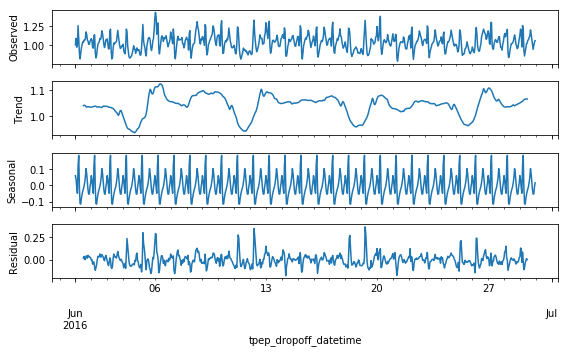

In [432]:
# Le choix du modèle, additif ou multiplicatif, importe peu car la tendance est quasiment une droite à l'échelle de la série
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition0 = seasonal_decompose(np.log(ts_hourly), model='additive')
decomposition0.plot()
plt.show()

Comme nous pouvons le constater, en laissant à la commande seasonal_decompose la choix de la fréquence, on obtient une tendance un peu particulière. Ses cycles ne semblent pas aléatoires, ils correspondent plutôt à des intervalles d'une semaine. Pour corriger ce problème, on préfèrera spécifier nous même la fréquence pour la décomposition de la série :

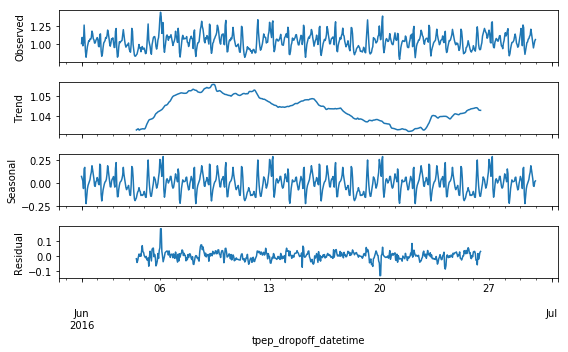

In [433]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 5
decomposition = seasonal_decompose(np.log(ts_hourly), model='additive',freq=7*24)
decomposition.plot()
plt.show()
# On a donc season_t[0:7*24].reset_index(drop=True)==season_t[7*24:7*24*2].reset_index(drop=True)
# la série "season" est telle que la valeur prise chaque lundi à 13h est la même

On va donc conserver les résidus de cette seconde décomposition. Notons que l'on a testé les deux à l'aide du test qui suit, que les deux séries de résidus donnent une p-value très faible, mais qu'elle est nettement plus faible pour la deuxième décomposition. Il n'y a donc pas de raisons de préférer la première.

In [380]:
#Remarque : il est aussi possible de rendre la série plus stationnaire par des commandes du type :
#differentiated_ts_hourly=(ts_hourly).shift(periods=24)
#differentiated_ts_hourly=differentiated_ts_hourly.dropna()
#Cela dit, Comme nous allons le voir, la p-value du test de stationarité des résidus est déjà encourageante. La différentiation
#nous faisant perdre quelques observations sans grandes améliorations, nous décidons d'en rester à la décomposition ci-dessus.

Les graphiques ci-dessus nous confortent dans l'idée que les données suivent une période d'une semaine et une période de 24 heures. La forme de la tendance n'est pas surprenante au vu de ce que l'on a observé précédemment. Nous observons en effet des périodes d'une semaine, avec une baisse au moment du weekend (le premier juin est un mercredi, les valeurs chutent pour la première fois entre vendredi après-midi et dimanche soir).

# Vérifier la présence d'autocorrélation des résidus

## Stationarité de la série

Tant que la série n'est pas stationnaire, nous ne pouvons pas mettre en place notre modèle de série temporelle. Nous vérifions la stationnarité de notre série (la série originale et la série des résidus). Pour savoir si une série est stationnaire, on peut faire un test de Dickey Fuller.

In [434]:
# série des résidus dans la décomposition selon la semaine
from pandas import Series
from statsmodels.tsa.stattools import adfuller
X = decomposition0.resid.dropna()['tip_amount']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %.ef' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.736301
p-value: 3e-19f
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [435]:
# série des résidus
from pandas import Series
from statsmodels.tsa.stattools import adfuller
X = decomposition.resid.dropna()['tip_amount']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %.ef' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.154532
p-value: 2e-22f
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


La p-value est très faible, ce qui nous encourage à penser que la série est stationnaire. Le rejet de l'hypothèse nulle signifie que le processus n'a pas de racine unitaire. Il revient à rejeter la non-stationnarité, ce qui nous permet de penser que la série temporelle est stationnaire. La p-value pour la série des résidus est nettement plus faible que la p-value de la série non décomposée, on préfère donc travailler sur la série des résidus

## Choix des ordres p et q

Notes pour l'interprétation des graphiques :

###### L'autocorrélogramme
Nous donne les coefficients de corrélation :
- entre la variable X_t et la variable X_(t-1)
- entre la variable X_t et la variable X_(t-2)
- etc.

De l'autocorrélogramme, nous tirons une idée de l'ordre maximal à tester pour la partie MA de notre modèle

###### L'autocorrélogramme partiel
Nous donne les coefficients d'autocorrélation :
- entre la variable X_t et la variable X_(t-1)
- entre la variable X_t et la variable X_(t-2) sans l'influence de la variable X_(t-1)
- entre la variable X_t et la variable X_(t-2) sans l'influence des variables X_(t-1) et X_(t-2)
- etc.

De l'autocorrélogramme partiel, nous tirons une idée de l'ordre maximal à tester pour la partie AR de notre modèle


###### En bleu : l'intervalle de confiance
Certains coefficients sortent de l'intervalle de confiance. Cela indique qu'il y a un problème d'autocorrélation dans la série

Générons ces graphiques :

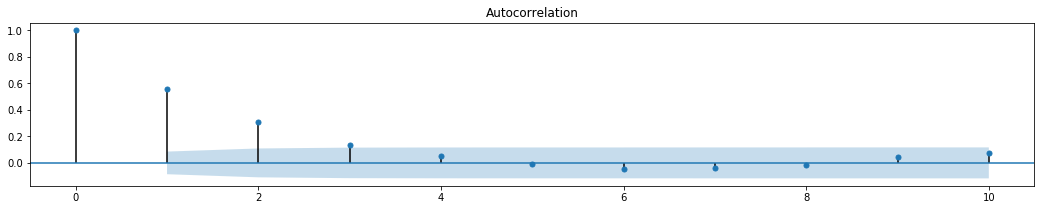

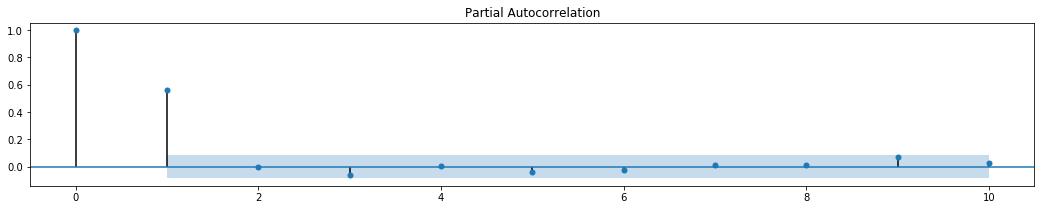

In [383]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 3
plt.rcParams["figure.figsize"] = fig_size
fig = plt.figure()
ax1 = fig.add_subplot()
fig = plot_acf(decomposition.resid.dropna(), lags=10, ax=ax1)
ax2 = fig.add_subplot()
fig = plot_pacf(decomposition.resid.dropna(), lags=10, ax=ax2)
plt.show()

Que tirer de ces graphs ? Nous avons représentés l'autocorrélation pour la même série temporelle (les tips heure par heure). Nous voyons une forte corrélation entre X_t et X_(t-1), X_t et X_(t-2), X_t et X_(t-3) (ACF). Il semblerait que l'ordre maximal à tester pour la partie MA soit 3 et l'ordre maximal à tester pour la partie AR soit 1. On pourrait avoir un doute pour l'ordre 3 pour Pmax, c'est pourquoi on va regarder les modèles jusqu'aux ordres 3 pour p et q. (Remarque : si on regarde les corrélations avec plus de lags, on n'a pas complètement fait disparaître la corrélation entre X_t et X_(t+168(une semaine)) mais elle est très faible. On la néglige ici du fait de sa faiblesse relative et de la puissance de calcul nécessaire mais on pourrait sur cette base tester d'autres ordres pour notre AR et notre MA).

### Critères de sélection de nos ordres : AIC et BIC

In [384]:
Qmax = 3
Pmax = 1
tseries = decomposition.resid.dropna()
a = pd.DataFrame(index=range(Pmax+1), columns=range(Qmax+1))
a.index.names = ['P']
a.columns.names = ['Q']

from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm
import numpy as np

res = sm.tsa.arma_order_select_ic(tseries, max_ar=Pmax, max_ma=Qmax, ic=['aic', 'bic'], trend='c')

In [385]:
res.aic

,0,1,2,3
0,-2250.693436,-2396.282719,-2438.619688,-2442.327492
1,-2446.951974,-2444.952002,-2444.712295,-2442.735889


In [386]:
res.bic

,0,1,2,3
0,-2242.155244,-2383.475430,-2421.543303,-2420.982010
1,-2434.144685,-2427.875617,-2423.366814,-2417.121311


In [387]:
print(res.aic_min_order)
print(res.bic_min_order)

(1, 0)
(1, 0)


Les deux critères font ressortir l'AR(1), ce qui n'est pas particulièrement conforme à notre première intuition à la vue des autocorrélogrammes. Pour ne pas écarter des modèles intéressants, nous avons présenté l'ensemble des résultats. Pour le critère AIC, les modèles avec un AR(1) donnent des résultats proches. Le modèle MA(3) aussi. Concernant le critère BIC, les modèles AR(1), ARMA(1,1) et ARMA(1,2) sont les plus proches. Nous testerons donc ces trois modèles car ils croisent les deux critères et nos conclusions sur les autocorrélogrammes.

- Modele 1 : AR(1)
- Modele 2 : ARMA(1,1)
- Modele 3 : ARMA(1,2)

In [388]:
from statsmodels.tsa.arima_model import ARMA
modele1 = ARMA(tseries, (1, 0)).fit()
modele2 = ARMA(tseries, (1, 1)).fit()
modele3 = ARMA(tseries, (1, 2)).fit()

In [389]:
print('Résultats modèle 1 :')
print(modele1.summary().tables[1])
print("")
print('Résultats modèle 2 :')
print(modele2.summary().tables[1])
print("")
print('Résultats modèle 3 :')
print(modele3.summary().tables[1])

Résultats modèle 1 :
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0009      0.002      0.404      0.687      -0.004       0.006
ar.L1.tip_amount     0.5597      0.036     15.528      0.000       0.489       0.630

Résultats modèle 2 :
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0009      0.002      0.404      0.687      -0.004       0.006
ar.L1.tip_amount     0.5599      0.060      9.266      0.000       0.441       0.678
ma.L1.tip_amount    -0.0004      0.071     -0.005      0.996      -0.139       0.138

Résultats modèle 3 :
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------


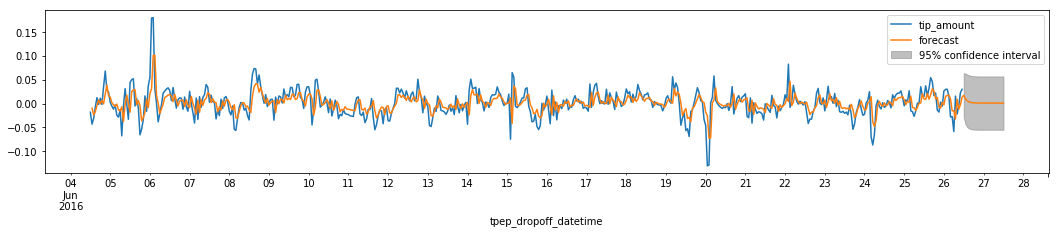

In [390]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
fig, ax = plt.subplots()
ax = tseries.loc['2016-06-04 12:00:00':].plot(ax=ax)
fig = modele1.plot_predict('2016-06-04 13:00:00', '2016-06-27 12:00:00', ax=ax, plot_insample=False)
plt.show()

Voici ce que l'on obtient avec l'AR appliqué à notre jeu de données. L'AR(1) ayant un coefficient de 0.6, il converge assez rapidement vers une moyenne (au bout de quelques heures). L'intervalle de confiance pour la prédiction est assez large. On voit que le modèle AR(1) explique mal les hauts pics. Maintenant que nous avons une prédiction pour les résidus en moyenne nuls et avec une faible variance, nous pouvons expliquer une grande partie des fluctuations avec la tendance et la saisonnalité en y ajoutant l'AR(1) de coefficient 0.5597 et de moyenne nulle.

In [391]:
predict=Series(modele1.predict(start='2016-06-04 13:00:00', end='2016-06-26 12:00:00'))
predict.index=tseries.index
predict=pd.DataFrame(predict).rename(columns={0:'tip_amount'})
trend_t=decomposition.trend.loc[decomposition.trend['tip_amount'].notna()]
season_t=decomposition.seasonal.loc[decomposition.trend['tip_amount'].notna()]
predict_tot=trend_t.mean()+season_t+predict

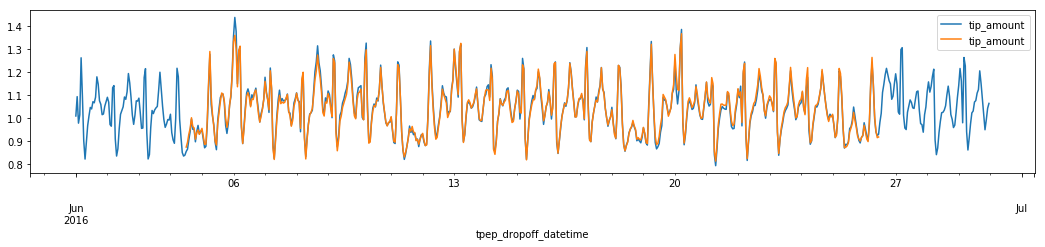

In [392]:
fig, ax = plt.subplots()
ax = np.log(ts_hourly).plot(ax=ax)
fig = predict_tot.plot(ax=ax)
plt.show()

## Prévision des valeurs à partir du 23 juin : faut-il préférer décomposer la série en saisonalité de période d'un jour ou d'une semaine ? 
Nous allons maintenant supposer que nous ne connaissons pas les dernières valeurs de juin sur une semaine. Nous comparons deux modèles, l'un où l'on a décomposé la tendance en jours comme le suggère automatiquement la commande décompose et l'un où l'on suit la semaine.

### Saison = Semaine

Découpons les données en deux sous échantillon. Le premier va servir à mettre en place le modèle, c'est-à-dire définir une tendance, une saisonnalité et 

In [393]:
#definir saisonnalité
saison = 24*7
demisaison=int(24*7/2)

#on va chercher à prédire les valeurs hors échantillon sur les derniers 7 jours
longX_train=7*24
longX_test=len(ts_hourly)-longX_train
X_test=ts_hourly[:longX_test]
X_train=ts_hourly[longX_test:]


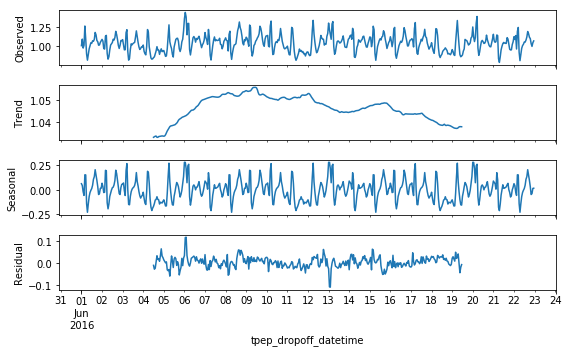

In [394]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 5
decomposition = seasonal_decompose(np.log(X_test), model='additive',freq=7*24)
decomposition.plot()
plt.show()
# On a donc season_t[0:7*24].reset_index(drop=True)==season_t[7*24:7*24*2].reset_index(drop=True)
# la série "season" est telle que la valeur prise chaque lundi à 13h est la même

In [395]:
len(trend_t)

528

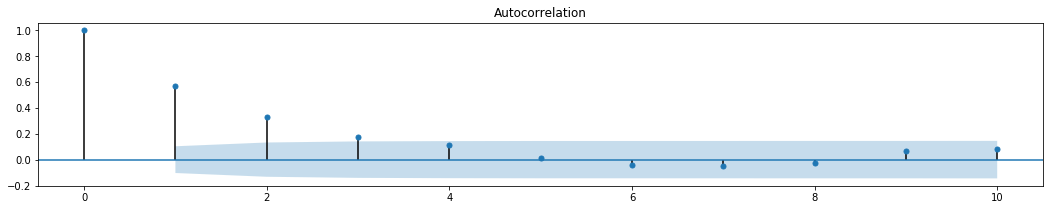

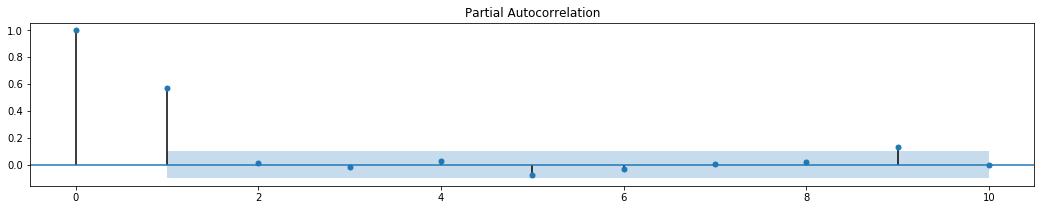

In [396]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 3
plt.rcParams["figure.figsize"] = fig_size
fig = plt.figure()
ax1 = fig.add_subplot()
fig = plot_acf(decomposition.resid.dropna(), lags=10, ax=ax1)
ax2 = fig.add_subplot()
fig = plot_pacf(decomposition.resid.dropna(), lags=10, ax=ax2)
plt.show()

In [397]:
#L'AR(1) est toujours suggéré pour les résidus
Qmax = 4
Pmax = 1
tseries = decomposition.resid.dropna()
a = pd.DataFrame(index=range(Pmax+1), columns=range(Qmax+1))
a.index.names = ['P']
a.columns.names = ['Q']

from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm
import numpy as np

res = sm.tsa.arma_order_select_ic(tseries, max_ar=Pmax, max_ma=Qmax, ic=['aic', 'bic'], trend='c')
print(res.aic_min_order)
print(res.bic_min_order)

(1, 0)
(1, 0)


In [398]:
from statsmodels.tsa.arima_model import ARMA
modele1 = ARMA(tseries, (1, 0)).fit()

In [399]:
# Prédiction des résidus
resid_predict=Series(modele1.predict(start=decomposition.trend.dropna().index[0], end=ts_hourly.index[len(ts_hourly)-1]))
index_resid_predict=ts_hourly.index[ts_hourly.index>=decomposition.trend.dropna().index[0]]
resid_predict.index=index_resid_predict
# On le passe en dataframe pour faciliter la mise en place des graphs
resid_predict=pd.DataFrame(resid_predict).rename(columns={0:'tip_amount'})
# On ne s'intéresse que à la prédiction dans la dernière saison + demi saison
resid_predict=resid_predict[len(decomposition.trend.dropna().index):]

In [400]:
#Prédiction de la saisonalité : on doit prédire une saison et demi, la première moitié étant dans l'échantillon X_test
season_predict=decomposition.seasonal[demisaison-1:saison*2-1]
season_predict.index=ts_hourly.index[len(X_test)-demisaison:]

In [401]:
#Prédiction de la tendance : on fit la tendance avec un polynome de degré 3
coefs=np.polyfit(range(len(decomposition.trend.dropna())), decomposition.trend.dropna()['tip_amount'], deg=3, rcond=None, full=False)
trendfit_predict=Series(np.poly1d(coefs)(range(len(X_test)+len(X_train)-demisaison)))
#On ne prend que la prédiction sur la fin
trendfit_predict=Series(trendfit_predict[len(X_test)-demisaison-demisaison:])
trendfit_predict.index=resid_predict.index

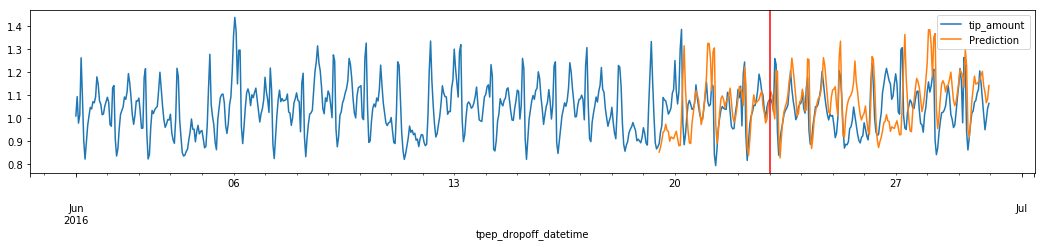

In [402]:
#Prédiction totale
prediction_totale_semaine=resid_predict.add(season_predict, axis=1).add(trendfit_predict, axis=0)
datatoplotsemaine=pd.DataFrame(np.log(ts_hourly)['tip_amount'])
datatoplotsemaine['Prediction']=prediction_totale_semaine
fig, ax = plt.subplots()
ax = datatoplotsemaine.plot(ax=ax)
fig = plt.axvline(x=X_train.index[0],color='red')
plt.show()

La courbe orange débute à la fin de l'échantillon test car on a retiré une saison d'une semaine à l'échantillon test, et que la tendance et les résidus qui résultent de la décomposition sont "tronqués" d'une demi-saison au début et à la fin. Notre tendance étant définie comme un polynome dépendant de t et nos résidus étant des AR(1) qui dépendent des valeurs prises précédement, nous prolongeons la prédiction sur la fin de l'échantillon test. Cependant, ce qui nous intéresse réellement, est bien sûr la prédiction hors échantillon, c'est-à-dire sur X_test, c'est-à-dire, la prédiction dans la dernière semaine de juin à partir du 23 juin. Cette période est remarquée par la ligne rouge. On voit qu'on tend à s'éloigner des valeurs prédites au fur et à mesure que l'on s'éloigne de l'échantillon test. Ce n'est pas surprenant : nous avons fité les modèles sur l'échantillon test et pour peu qu'une tendance existe sur le mois que nous ne connaissons pas (nous n'avons pas regardé les données sur les autres mois), nous manquant peut-être une tendance de fin de mois qui est à l'origine d'une différentiation de la dernière semaine par rapport aux trois première. Nous ne l'avons pas représenté ici mais nous pouvons rappeler que le même modèle utilisé en première partie montrait une grande proximité avec les données lorsque l'on examinait l'échantillon entier, nous pourrions refaire le même exercice pour soutenir graphiquement notre propos, mais nous sommes davantage intéressés par la comparaison de ce modèle avec le suivant.

### Saison = jour

In [451]:
#definir saisonnalité
saison = 24
demisaison=int(24/2)

#on va chercher à prédire les valeurs hors échantillon sur les derniers 7 jours
longX_train=7*24
longX_test=len(ts_hourly)-longX_train
X_test=ts_hourly[:longX_test]
X_train=ts_hourly[longX_test:]


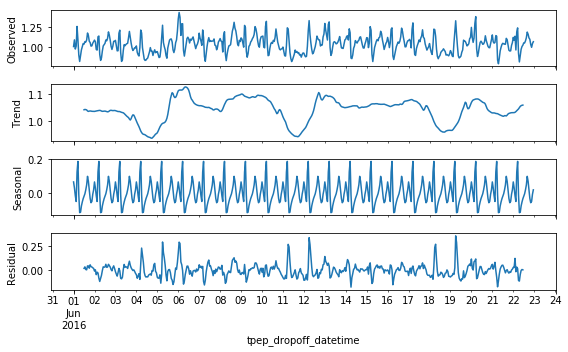

In [452]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 5
decomposition = seasonal_decompose(np.log(X_test), model='additive',freq=saison)
decomposition.plot()
plt.show()
# On a donc season_t[0:7*24].reset_index(drop=True)==season_t[7*24:7*24*2].reset_index(drop=True)
# la série "season" est telle que la valeur prise chaque lundi à 13h est la même

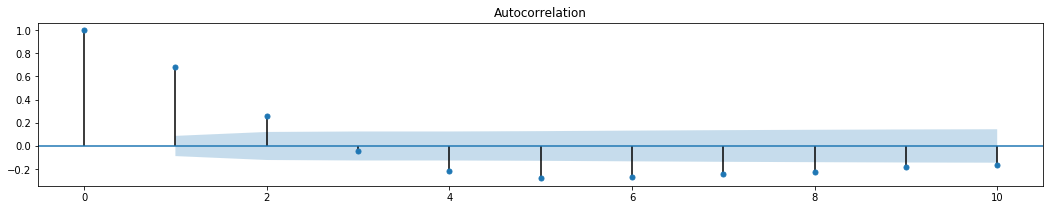

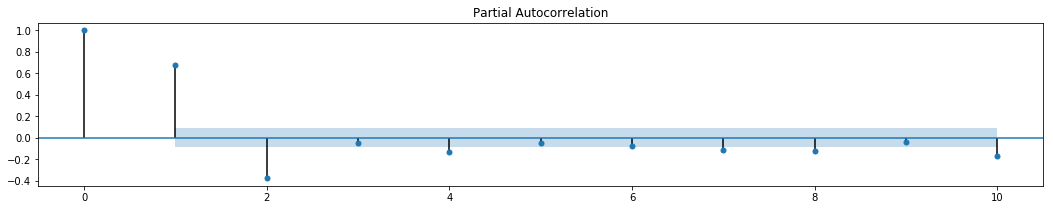

In [453]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 3
plt.rcParams["figure.figsize"] = fig_size
fig = plt.figure()
ax1 = fig.add_subplot()
fig = plot_acf(decomposition.resid.dropna(), lags=10, ax=ax1)
ax2 = fig.add_subplot()
fig = plot_pacf(decomposition.resid.dropna(), lags=10, ax=ax2)
plt.show()

In [454]:
#L'ARMA(1,3) est toujours suggéré pour les résidus
# pour Qmax = 8 et Pmax = 2 (suggéré par les autocorrélogrammes) le modèle ARMA(2,2) est suggéré par les deux critères, cependant
# la fonction ARMA doit gérer des coefficients initiaux de l'ARMA qui ne sont pas inversibles, ce qui l'empêche d'estimer le 
# modèle. On pourrait mettre nous mêmes les coefficients initiaux.
Qmax = 3
Pmax = 1
tseries = decomposition.resid.dropna()
a = pd.DataFrame(index=range(Pmax+1), columns=range(Qmax+1))
a.index.names = ['P']
a.columns.names = ['Q']

from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm
import numpy as np

res = sm.tsa.arma_order_select_ic(tseries, max_ar=Pmax, max_ma=Qmax, ic=['aic', 'bic'], trend='c')
print(res.aic_min_order)
print(res.bic_min_order)

(1, 3)
(1, 3)


In [455]:
from statsmodels.tsa.arima_model import ARMA
modele1 = ARMA(tseries, (1, 3)).fit()

In [456]:
# Prédiction des résidus
resid_predict=Series(modele1.predict(start=decomposition.trend.dropna().index[0], end=ts_hourly.index[len(ts_hourly)-1]))
index_resid_predict=ts_hourly.index[ts_hourly.index>=decomposition.trend.dropna().index[0]]
resid_predict.index=index_resid_predict
# On le passe en dataframe pour faciliter la mise en place des graphs
resid_predict=pd.DataFrame(resid_predict).rename(columns={0:'tip_amount'})
# On ne s'intéresse que à la prédiction dans la dernière saison + demi saison
resid_predict=resid_predict[len(decomposition.trend.dropna().index):]

In [457]:
#Prédiction de la saisonalité : on doit prédire une saison et demi, la première moitié étant dans l'échantillon X_test
season_predict=decomposition.seasonal[demisaison-1:len(X_train)+saison-1]
season_predict.index=ts_hourly.index[len(X_test)-demisaison:]

In [458]:
#Prédiction de la tendance : on fit la tendance avec un polynome de degré 3
coefs=np.polyfit(range(len(decomposition.trend.dropna())), decomposition.trend.dropna()['tip_amount'], deg=3, rcond=None, full=False)
trendfit_predict=Series(np.poly1d(coefs)(range(len(X_test)+len(X_train)-demisaison)))
#On ne prend que la prédiction sur la fin
trendfit_predict=Series(trendfit_predict[len(X_test)-demisaison-demisaison:])
trendfit_predict.index=resid_predict.index

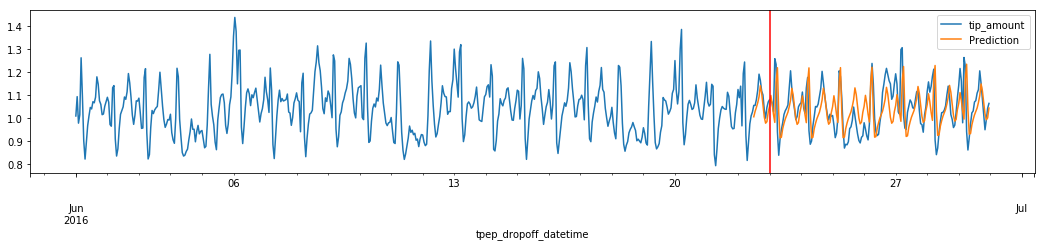

In [459]:
#Prédiction totale
prediction_totale_jour=resid_predict.add(season_predict, axis=1).add(trendfit_predict, axis=0)
datatoplotjour=pd.DataFrame(np.log(ts_hourly))
datatoplotjour['Prediction']=prediction_totale_jour
fig, ax = plt.subplots()
ax = datatoplotjour.plot(ax=ax)
fig = plt.axvline(x=X_train.index[0],color='red')
plt.show()

#### Comparaison des MSE et conclusion
Ils sont calculés à partir de la ligne rouge sur les graphiques ci-dessus

In [460]:
mse_semaine=((prediction_totale_semaine['tip_amount']-np.log(ts_hourly)['tip_amount']).dropna()).apply(lambda x: x**2)[X_train.index[0]:].mean()
mse_jour=((prediction_totale_jour['tip_amount']-np.log(ts_hourly)['tip_amount']).dropna()).apply(lambda x: x**2)[X_train.index[0]:].mean()
print('MSE pour le modèle avec la semaine comme saison : {0}'.format(mse_semaine))
print('MSE pour le modèle avec le jour comme saison : {0}'.format(mse_jour))

MSE pour le modèle avec la semaine comme saison : 0.01651812681821216
MSE pour le modèle avec le jour comme saison : 0.00893104706250848


A la vue des MSE on préférera donc le modèle avec la semaine comme saison plutôt que le jour, et ce même si un argument en faveur de la décomposition avec la semaine comme saison était apporté en première partie (la stationnarité des résidus était davantage assurée même si elle l'était déjà pour le modèle avec le jour en saison). 

#### Automatisation de la recherche de la saison optimale
Ci-dessus on a comparé uniquement deux modèles en nous basant sur notre intuition et notre visualisation de la série : il semblait y avoir une saisonnalité par jour et par semaine, et nous ne savions pas laquelle préférer pour la prédiction. Supposons maintenant que nous ayant mal repéré la saisonnalité de la série à l'oeil nu. Pour simplifier, nous allons systématiquement modéliser les résidus sous forme d'une constante égale à sa moyenne (comme nous ne pourrons pas regarder les autocorrélogrammes pour toutes les régressions et déterminer ainsi Pmax et Qmax, et comme les résidus semblent peu varier jusque là relativement à la saisonnalité nous estimons que cela changera peu nos prévisions). Pour simplifier également les indices, on regarde toutes les saisonnalités de 2 en 2

In [638]:
MSE=[]
# On s'arrête à un peu plus d'une semaine et demie (268 heures) comme saisonnalité possible (on n'a pas plus de cinq semaines
# dans nos données)
for u in range(1,134):
    i = 2*u
    saison = i
    demisaison=int(saison/2)
    #on va chercher à prédire les valeurs hors échantillon sur les derniers 7 jours
    longX_train=7*24
    longX_test=len(ts_hourly)-longX_train
    X_test=ts_hourly[:longX_test]
    X_train=ts_hourly[longX_test:]
    decomposition = seasonal_decompose(np.log(X_test), model='additive',freq=saison)
    import statsmodels.api as sm
    import numpy as np
    # Prédiction des résidus
    predict_resid_mean=decomposition.resid.mean()
    #Prédiction de la saisonalité : on doit prédire une saison et demi, la première moitié étant dans l'échantillon X_test
    season_predict=decomposition.seasonal[demisaison-1:len(X_train)+saison-1]
    season_predict.index=ts_hourly.index[len(X_test)-demisaison:]
    #Prédiction de la tendance : on fit la tendance avec un polynome de degré 3
    coefs=np.polyfit(range(len(decomposition.trend.dropna())), decomposition.trend.dropna()['tip_amount'], deg=3, rcond=None, full=False)
    trendfit_predict=Series(np.poly1d(coefs)(range(len(X_test)+len(X_train)-demisaison)))
    #On ne prend que la prédiction sur la fin
    trendfit_predict.index=ts_hourly.index[ts_hourly.index>=decomposition.trend.dropna().index[0]]
    #Prédiction totale
    prediction_totale_jour=season_predict.add(trendfit_predict, axis=0).dropna()+predict_resid_mean
    datatoplotjour=pd.DataFrame(np.log(ts_hourly)[ts_hourly>=X_test.iloc[len(X_test)-demisaison-1]])
    datatoplotjour['Prediction']=prediction_totale_jour
    MSE=MSE+[((prediction_totale_jour['tip_amount']-np.log(ts_hourly)['tip_amount']).dropna()).apply(lambda x: x**2)[X_train.index[0]:].mean()]
# on fait attention au fait que np.nanargmin(MSE) est décalé d'un par rapport à u. De plus i=2*u est la saison
print('La saisonnalité qui donne le MSE le plus petit est la saisonnalité de {0} heure(s)'.format((np.nanargmin(MSE)+1)*2))
print('La MSE vaut alors {0}'.format(min(MSE)))

La saisonnalité qui donne le MSE le plus petit est la saisonnalité de 12 heure(s)
La MSE vaut alors 0.008636254554780898


Bilan : En cherchant automatiquement on obtient une décomposition de la série qui donne de meilleures prédictions (que freq saison=jour). Cependant il est peut-être possible de modéliser mieux les résidus que l'on a simplifié ici par une constante mais qui pourraient être modélisés plus finement (on a vu précédemment qu'un AR ou un ARMA pouvait être mis en oeuvre) ce qui pourrait nous faire perdre de l'erreur notamment pour les prévisions des données du test les plus proches de celles du train (puisqu'ensuite les résidus convergent généralemennt rapidement vers 0)

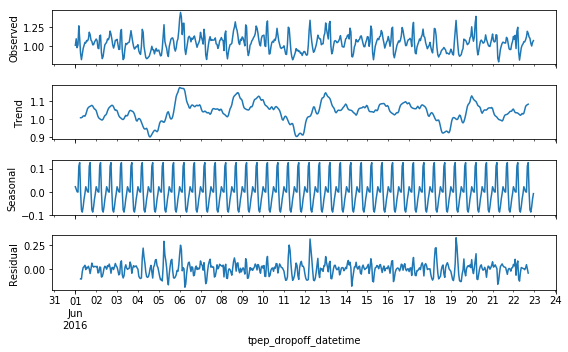

In [639]:
saison = 12
demisaison=int(saison/2)
longX_train=7*24
longX_test=len(ts_hourly)-longX_train
X_test=ts_hourly[:longX_test]
X_train=ts_hourly[longX_test:]
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 5
decomposition = seasonal_decompose(np.log(X_test), model='additive',freq=saison)
decomposition.plot()
plt.show()

In [651]:
# série des résidus dans la décomposition en demi-journée, stationnaire
from pandas import Series
from statsmodels.tsa.stattools import adfuller
X = decomposition.resid.dropna()['tip_amount']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %.ef' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.173995
p-value: 7e-18f
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


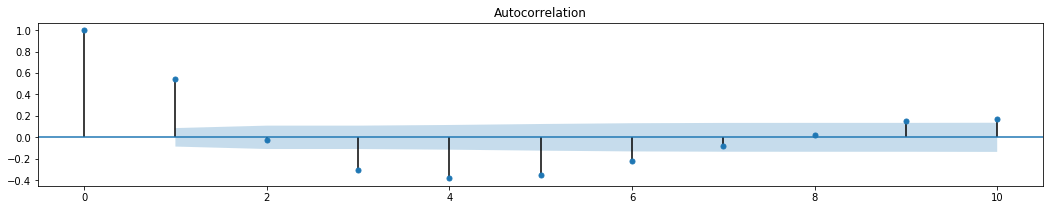

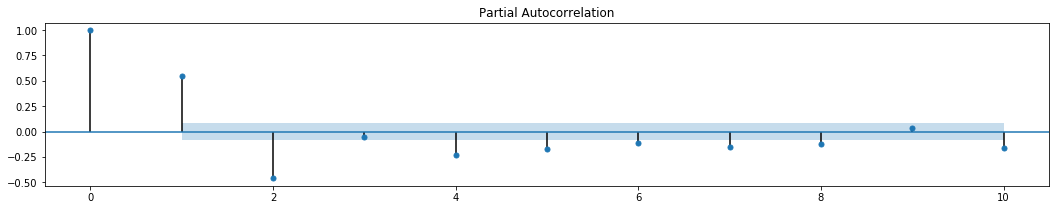

In [640]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 3
plt.rcParams["figure.figsize"] = fig_size
fig = plt.figure()
ax1 = fig.add_subplot()
fig = plot_acf(decomposition.resid.dropna(), lags=10, ax=ax1)
ax2 = fig.add_subplot()
fig = plot_pacf(decomposition.resid.dropna(), lags=10, ax=ax2)
plt.show()

In [682]:
# On tests les autres ordres, de nombreux modeles ne peuvent pas être estimés. Nous nous arrêtons donc sur ces ordres
Qmax = 1
Pmax = 3
tseries = decomposition.resid.dropna()
a = pd.DataFrame(index=range(Pmax+1), columns=range(Qmax+1))
a.index.names = ['P']
a.columns.names = ['Q']

from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm
import numpy as np

res = sm.tsa.arma_order_select_ic(tseries, max_ar=Pmax, max_ma=Qmax, ic=['aic', 'bic'], trend='c')
print(res.aic_min_order)
print(res.bic_min_order)
# !!!!!!!!!!!!!!!!!
# une erreur s'affiche, nous vérifions qu'elle ne concerne pas ARMA(3,1) mais d'autres ordres en lançant la commande suivant
# qui ne présente pas d'erreurs
# !!!!!!!!!!!!!!!!

c:\programdata\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 1)
(3, 1)


In [692]:
from statsmodels.tsa.arima_model import ARMA
modele1 = ARMA(tseries, (3, 1)).fit()
print('Résultats modèle 1 :')
print(modele1.summary().tables[1])


Résultats modèle 1 :
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -9.741e-06   4.96e-05     -0.196      0.844      -0.000    8.75e-05
ar.L1.tip_amount     1.4924      0.044     34.247      0.000       1.407       1.578
ar.L2.tip_amount    -0.9276      0.067    -13.752      0.000      -1.060      -0.795
ar.L3.tip_amount     0.1556      0.044      3.567      0.000       0.070       0.241
ma.L1.tip_amount    -1.0000      0.005   -203.337      0.000      -1.010      -0.990


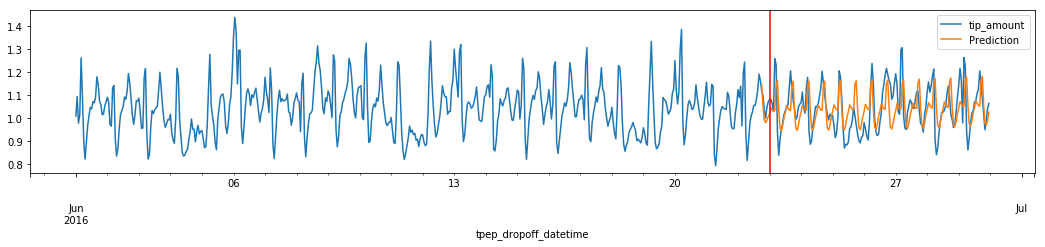

In [693]:
# Prédiction des résidus
resid_predict=Series(modele1.predict(start=decomposition.trend.dropna().index[0], end=ts_hourly.index[len(ts_hourly)-1]))
index_resid_predict=ts_hourly.index[ts_hourly.index>=decomposition.trend.dropna().index[0]]
resid_predict.index=index_resid_predict
# On le passe en dataframe pour faciliter la mise en place des graphs
resid_predict=pd.DataFrame(resid_predict).rename(columns={0:'tip_amount'})
# On ne s'intéresse que à la prédiction dans la dernière saison + demi saison
resid_predict=resid_predict[len(decomposition.trend.dropna().index):]
#Prédiction de la saisonalité : on doit prédire une saison et demi, la première moitié étant dans l'échantillon X_test
season_predict=decomposition.seasonal[demisaison-1:len(X_train)+saison-1]
season_predict.index=ts_hourly.index[len(X_test)-demisaison:]
#Prédiction de la tendance : on fit la tendance avec un polynome de degré 3
coefs=np.polyfit(range(len(decomposition.trend.dropna())), decomposition.trend.dropna()['tip_amount'], deg=3, rcond=None, full=False)
trendfit_predict=Series(np.poly1d(coefs)(range(len(X_test)+len(X_train)-demisaison)))
#On ne prend que la prédiction sur la fin
trendfit_predict=Series(trendfit_predict[len(X_test)-demisaison-demisaison:])
trendfit_predict.index=resid_predict.index
#Prédiction totale
prediction_totale_jour=resid_predict.add(season_predict, axis=1).add(trendfit_predict, axis=0)
datatoplotjour=pd.DataFrame(np.log(ts_hourly))
datatoplotjour['Prediction']=prediction_totale_jour
fig, ax = plt.subplots()
ax = datatoplotjour.plot(ax=ax)
fig = plt.axvline(x=X_train.index[0],color='red')
plt.show()
MSE_ARMA_12h=((prediction_totale_jour['tip_amount']-np.log(ts_hourly)['tip_amount']).dropna()).apply(lambda x: x**2)[X_train.index[0]:].mean()


In [694]:
print('{0} = MSE avec résidus ARMA'.format(MSE_ARMA_12h))
print('{0} = MSE avec moyenne des résidus'.format(min(MSE)))
print('MSE avec modélisation en ARMA des résidus > MSE avec moyenne des résidus ? : {0} !'.format(MSE_ARMA_12h>min(MSE)))

0.008659793924891244 = MSE avec résidus ARMA
0.008636254554780898 = MSE avec moyenne des résidus
MSE avec modélisation en ARMA des résidus > MSE avec moyenne des résidus ? : True !


### Conclusion
Si les résidus se modélisent bien en ARMA(3,1) au vu des coefficients, cette modélisation n'est pas très concluante. Comme ils sont très faibles en moyenne et qu'ils varient peu, cela a peu d'effet sur notre prédiction. Cela a même un effet regrettable sur notre prédiction puisque nous prédisons moins bien ! C'est assez contrinuitif dans la mesure où l'ARMA pour les résidus est mieux adapté au jeu de données X_train (c'est le modèle sélectionné par les deux critères AIC et BIC). Il serait intéressant de comparer ces résultats avec des jeux de données sur d'autres mois pour savoir si cela est du à une erreur de modélisation sur le train (une surindentification sur la base de critères de sélection du modèle) ou au fait que les résidus de la fin du mois de juin ne sont pas autocorrélés contrairement aux autres périodes).